In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py

import pandas as pd
from tqdm import tqdm

from scipy.signal import savgol_filter

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [3]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2025-09-20.h5'

# We will want to look at longer trajectories here since we want to examine
# timescales longer than 10 seconds.
minimumLength = 15 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 15 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|███████| 393/393 [01:41<00:00,  3.88it/s]

Loaded 188 segments!


In [6]:
def meanSquaredDisplacement(trajectory, maxLag=100):
    """
    Compute the mean-squared displacement for a trajectory
    for a variety of lags.

    Parameters
    ----------
    trajectory : numpy.ndarray[N,d]
    """
    lagArr = np.arange(1, maxLag)
    msdArr = np.zeros(len(lagArr))

    for i in range(len(lagArr)):
        lag = lagArr[i]
        msdArr[i] = np.mean(np.sum((trajectory[lag:] - trajectory[:-lag])**2, axis=-1))
        
    return lagArr, msdArr

def computeSpeed(trajectory, dt=1):
    """
    """
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    speedArr = np.sqrt(np.sum(velocityArr**2, axis=-1))
    
    # Duplicate the first entry to it can be indexed the same
    # as the original trajectory
    speedArr = np.concatenate((speedArr[:1], speedArr))

    speedArr = savgol_filter(speedArr, 9, 1)
    return speedArr

In [13]:
maxTime = 60 # [s]
minSpeed = 0.5 # [mm/s]
dt = 1/metadataArr[0]["fps"]

# Make sure we don't take trajectories with objects in the
# enclosure, since that could introduce extra effects.
objectsArr = [metadataArr[i]["objects"] == "[]" for i in range(len(dataArr))]
goodIndices = np.where(objectsArr)[0]

maxLag = int(maxTime * metadataArr[goodIndices[0]]["fps"])
msdArr = np.zeros((len(goodIndices), maxLag-1))

for i in tqdm(range(len(goodIndices))):
    if len(dataArr[goodIndices[i]]) < 10:
        continue
    speed = computeSpeed(dataArr[goodIndices[i]], dt)
    trajectory = dataArr[goodIndices[i]][speed > minSpeed]
    lagArr, msdArr[i] = meanSquaredDisplacement(trajectory, maxLag=maxLag)

100%|█████████████████████████████████████████| 166/166 [00:16<00:00, 10.13it/s]


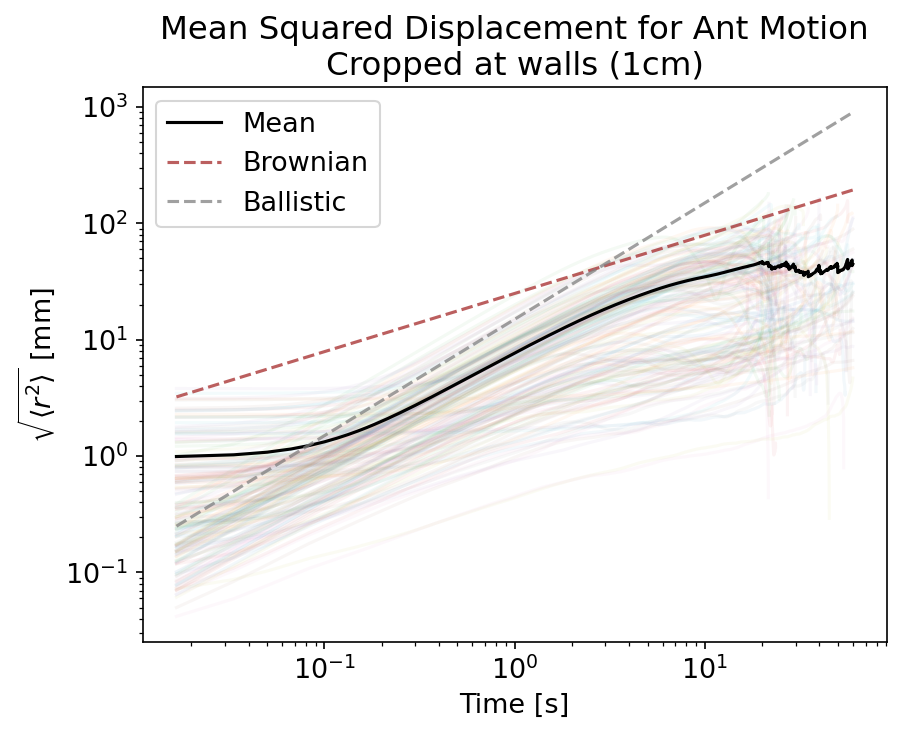

In [16]:
order = np.arange(len(goodIndices))
np.random.shuffle(order)
fps = metadataArr[0]["fps"]

for i in order:
    plt.plot(lagArr/fps, np.sqrt(msdArr[i]), '-', alpha=0.05)

mean = np.nanmean(msdArr, axis=0)

plt.plot(lagArr/fps, np.sqrt(mean), c='black', label='Mean')

plt.plot(lagArr/fps, 25*(lagArr/fps)**(1/2), '--', c='brown', label='Brownian', alpha=0.75)
plt.plot(lagArr/fps, 15*(lagArr/fps)**1, '--', c='gray', label='Ballistic', alpha=0.75)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('$\\sqrt{\\langle r^2 \\rangle}$ [mm]')
#plt.title(f'Mean Squared Displacement for Ant Motion\nUncropped')
plt.title(f'Mean Squared Displacement for Ant Motion\nCropped at walls (1cm)')
#plt.title(f'Mean Squared Displacement for Ant Motion\nOnly at walls (2 cm)')
plt.legend()
#pltsaveall('06_MSD')
plt.show()